In [1]:
import allel
import zarr
import numcodecs
import numpy as np
import sys

In [2]:
vcf_path = '../../../data/external_public/1kg_phase3/haps/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'

In [3]:
!ls -lh {vcf_path}

-rw-rw-r-- 1 abiddanda pi-jnovembre 205M Dec  6  2016 ../../../data/external_public/1kg_phase3/haps/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz


In [4]:
zarr_path = '../../../data/external_public/1kg_phase3/haps/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.zarr'

In [5]:
#allel.vcf_to_zarr(vcf_path, zarr_path, group='22', fields='*', log=sys.stdout, overwrite=True)

In [6]:
callset = zarr.open_group(zarr_path, mode='r')
callset.tree(expand=True)

ModuleNotFoundError: No module named 'ipytree'

/
 └── 22
     ├── calldata
     │   └── GT (1103547, 2504, 2) int8
     ├── samples (2504,) object
     └── variants
         ├── AA (1103547,) object
         ├── AC (1103547, 3) int32
         ├── AF (1103547, 3) float32
         ├── AFR_AF (1103547, 3) float32
         ├── ALT (1103547, 3) object
         ├── AMR_AF (1103547, 3) float32
         ├── AN (1103547,) int32
         ├── CHROM (1103547,) object
         ├── CIEND (1103547, 2) int32
         ├── CIPOS (1103547, 2) int32
         ├── CS (1103547,) object
         ├── DP (1103547,) int32
         ├── EAS_AF (1103547, 3) float32
         ├── END (1103547,) int32
         ├── EUR_AF (1103547, 3) float32
         ├── EX_TARGET (1103547,) bool
         ├── FILTER_PASS (1103547,) bool
         ├── ID (1103547,) object
         ├── IMPRECISE (1103547,) bool
         ├── MC (1103547,) object
         ├── MEINFO (1103547, 4) object
         ├── MEND (1103547,) int32
         ├── MLEN (1103547,) int32
         ├── MSTART (1103547,) 

In [7]:
g = allel.GenotypeChunkedArray(callset['22/calldata/GT'])
g

<GenotypeChunkedArray shape=(1103547, 2504, 2) dtype=int8 chunks=(65536, 64, 2)
   nbytes=5.1G cbytes=279.9M cratio=18.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [8]:
ac = g.count_alleles()[:]
ac

<AlleleCountsArray shape=(1103547, 9) dtype=int32>
5007    1    0    0    0    0    0    0    0
4976   32    0    0    0    0    0    0    0
4970   38    0    0    0    0    0    0    0
...
4969   39    0    0    0    0    0    0    0
5007    1    0    0    0    0    0    0    0
4989   19    0    0    0    0    0    0    0

In [9]:
np.count_nonzero(ac.max_allele()>1)

6346

In [10]:
np.count_nonzero((ac.max_allele()==1) & ac.is_singleton(1))

453783

In [11]:
flt = (ac.max_allele()==1) & (ac[:, :2].min(axis=1)>1)
gf = g.compress(flt, axis=0)
gf

<GenotypeChunkedArray shape=(639250, 2504, 2) dtype=int8 chunks=(625, 2504, 2)
   nbytes=3.0G cbytes=277.8M cratio=11.0
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [12]:
gn = gf.to_n_alt()
gn

<ChunkedArrayWrapper shape=(639250, 2504) dtype=int8 chunks=(1249, 2504)
   nbytes=1.5G cbytes=174.1M cratio=8.8
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [13]:
def plot_ld(gn, title):
    m = allel.rogers_huff_r(gn) ** 2
    ax = allel.plot_pairwise_ld(m)
    ax.set_title(title)

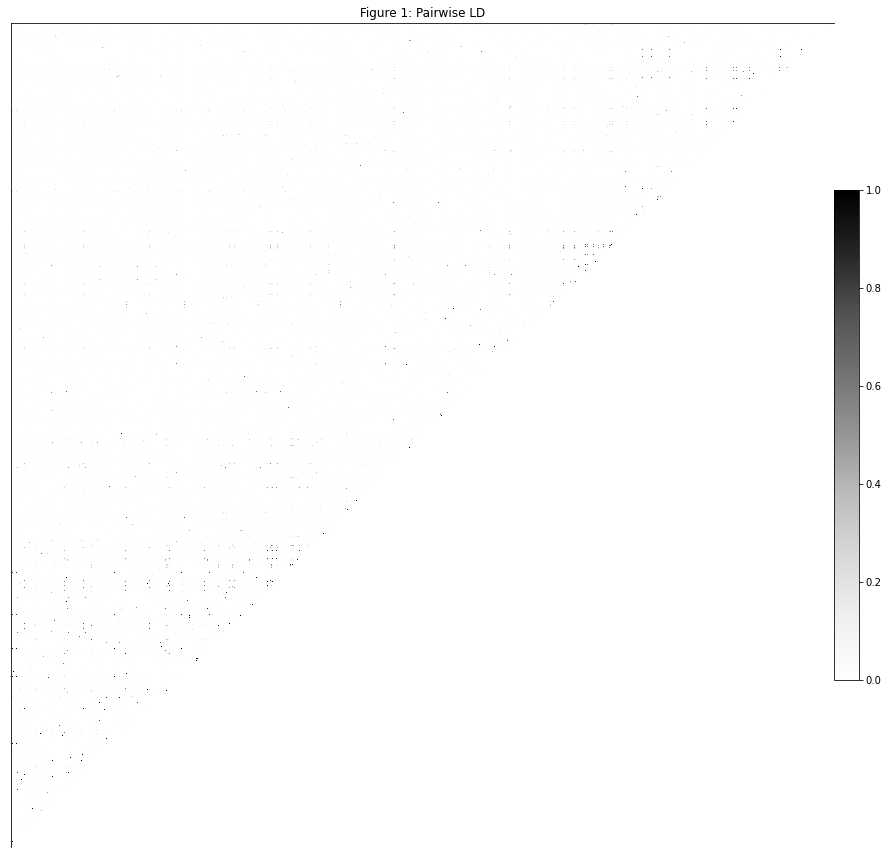

In [14]:
plot_ld(gn[:1000],'Figure 1: Pairwise LD')

In [15]:
# Trying a different way to get only CEU
panel_path = '../../../data/external_public/1kg_phase3/haps/integrated_call_samples_v3.20130502.ALL.panel'

In [16]:
!head {panel_path}

sample	pop	super_pop	gender		
HG00096	GBR	EUR	male
HG00097	GBR	EUR	female
HG00099	GBR	EUR	female
HG00100	GBR	EUR	female
HG00101	GBR	EUR	male
HG00102	GBR	EUR	female
HG00103	GBR	EUR	male
HG00105	GBR	EUR	male
HG00106	GBR	EUR	female


In [17]:
import pandas

In [18]:
panel = pandas.read_csv(panel_path, sep='\t',usecols=['sample','pop','super_pop'])
panel.head()

,sample,pop,super_pop
0,HG00096,GBR,EUR
1,HG00097,GBR,EUR
2,HG00099,GBR,EUR
3,HG00100,GBR,EUR
4,HG00101,GBR,EUR


In [19]:
panel.groupby(by=(['super_pop','pop'])).count()

sample
super_pop pop        
AFR       ACB      96
          ASW      61
          ESN      99
          GWD     113
          LWK      99
          MSL      85
          YRI     108
AMR       CLM      94
          MXL      64
          PEL      85
          PUR     104
EAS       CDX      93
          CHB     103
          CHS     105
          JPT     104
          KHV      99
EUR       CEU      99
          FIN      99
          GBR      91
          IBS     107
          TSI     107
SAS       BEB      86
          GIH     103
          ITU     102
          PJL      96
          STU     102

In [20]:
samples = callset['22/samples'][:]
samples

array(['HG00096', 'HG00097', 'HG00099', ..., 'NA21142', 'NA21143',
       'NA21144'], dtype=object)

In [21]:
np.all(samples==panel['sample'].values)

True

In [22]:
loc_samples_ceu = panel[panel['pop']=='CEU'].index.values
loc_samples_ceu

array([1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666,
       1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677,
       1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688,
       1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699,
       1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710,
       1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721,
       1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732,
       1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743,
       1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754])

In [23]:
len(loc_samples_ceu)

99

In [24]:
gt_ceu = g.take(loc_samples_ceu,axis=1)
gt_ceu

<GenotypeChunkedArray shape=(1103547, 99, 2) dtype=int8 chunks=(8622, 99, 2)
   nbytes=208.4M cbytes=10.0M cratio=20.9
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [25]:
ad = gt_ceu.count_alleles()[:]
ad

<AlleleCountsArray shape=(1103547, 7) dtype=int32>
198   0   0   0   0   0   0
198   0   0   0   0   0   0
198   0   0   0   0   0   0
...
198   0   0   0   0   0   0
198   0   0   0   0   0   0
197   1   0   0   0   0   0

In [26]:
np.count_nonzero(ad.max_allele()>1)

2083

In [27]:
np.count_nonzero((ad.max_allele()==1)&ad.is_singleton(1))

47999

In [28]:
flt1 = (ad.max_allele()==1) & (ad[:,:2].min(axis=1)>5)
gf1 = gt_ceu.compress(flt1,axis=0)
gf1

<GenotypeChunkedArray shape=(112408, 99, 2) dtype=int8 chunks=(3513, 99, 2)
   nbytes=21.2M cbytes=7.9M cratio=2.7
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [29]:
gn1 = gf1.to_n_alt()
gn1

<ChunkedArrayWrapper shape=(112408, 99) dtype=int8 chunks=(7026, 99)
   nbytes=10.6M cbytes=3.5M cratio=3.1
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [30]:
#plot_ld(gn1[:1000],'Figure 2: CEU Pairwise LD')

In [78]:
from scipy.spatial.distance import squareform
from tqdm import tqdm

def kxpfunc(gmat):
    emp = np.empty((500,0),dtype='float32')
    for i in tqdm(list(range(gmat.shape[0]-500))):
        e = np.append(emp,(np.reshape((squareform(np.square(allel.rogers_huff_r((gmat[i:i+500,:]).to_n_alt())))[:,0]),(500,1))),axis=1)
        emp = e
    return emp

In [39]:
kxp1 = kxpfunc(gf1[:56204,:])

100%|██████████| 55704/55704 [1:20:06<00:00, 11.59it/s]


In [40]:
kxp1

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.2713647e-03, 8.2290477e-01, 2.6286688e-02, ..., 2.7842051e-01,
        1.0000000e+00, 5.1878039e-02],
       [2.3470657e-04, 3.5056219e-02, 3.2411940e-02, ..., 2.7842051e-01,
        5.1878039e-02, 7.5970978e-02],
       ...,
       [6.9747196e-04, 2.8318621e-02, 5.8528211e-02, ..., 1.7158054e-01,
        9.3995884e-02, 1.5957982e-03],
       [5.2825683e-03, 4.6309453e-02, 9.0050623e-03, ..., 1.5782528e-01,
        1.5957982e-03, 2.0199681e-03],
       [5.6969975e-03, 7.2971159e-03, 3.5542224e-02, ..., 4.4230834e-05,
        2.0199681e-03, 9.3995884e-02]], dtype=float32)

In [63]:
kxp1.shape

(500, 55704)

In [42]:
kxp2 = kxpfunc(gf1[55705:,:])

100%|██████████| 56203/56203 [1:20:59<00:00, 11.57it/s]


In [64]:
kxp2

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.43557093, 0.43557093, 0.08813643, ..., 0.00962461, 0.08502483,
        0.2619038 ],
       [1.        , 0.17842394, 0.44011268, ..., 0.21745466, 0.01628778,
        0.21459994],
       ...,
       [0.04198174, 0.08988358, 0.04198174, ..., 0.03961617, 0.00215173,
        0.00743835],
       [0.23410733, 0.19000167, 0.10128729, ..., 0.01495998, 0.01252625,
        0.01491318],
       [0.04198174, 0.01836894, 0.02414387, ..., 0.03319456, 0.01548595,
        0.12671381]], dtype=float32)

In [65]:
kxp2.shape

(500, 56203)

In [68]:
kxp3 = kxpfunc(gf1[55704,:])

0it [00:00, ?it/s]


In [69]:
kxp3

array([], shape=(500, 0), dtype=float32)

In [46]:
kxpreal = np.concatenate((kxp1,kxp2),axis=1)

In [53]:
kxpreal.shape

(500, 111907)

In [52]:
#from numpy import savetxt
#savetxt('kxpreal.csv',kxpreal,delimiter=',')

In [85]:
%%time
b = allel.rogers_huff_r((gf1[:1000,:]).to_n_alt())
b.shape

CPU times: user 212 ms, sys: 1.01 ms, total: 213 ms
Wall time: 218 ms


(499500,)

In [91]:
a = np.corrcoef((gf1[:1000,:]).to_n_alt())
a.shape

(1000, 1000)

In [104]:
from scipy.spatial.distance import squareform
from tqdm import tqdm

def kxpfunc1(gmat):
    emp = np.zeros((500,gmat.shape[0]-500))
    for i in tqdm(list(range(gmat.shape[0]-500))):
        emp[:,i] == np.reshape((squareform(np.square(allel.rogers_huff_r((gmat[i:i+500,:]).to_n_alt())))[:,0]),(500,1))
    return emp

In [ ]:
kxpfunc1(gf1)

 27%|██▋       | 30482/111908 [28:12<1:15:20, 18.01it/s]

In [96]:
gf1

<GenotypeChunkedArray shape=(112408, 99, 2) dtype=int8 chunks=(3513, 99, 2)
   nbytes=21.2M cbytes=7.9M cratio=2.7
   compression=blosc compression_opts={'cname': 'lz4', 'clevel': 5, 'shuffle': 1, 'blocksize': 0}
   values=zarr.core.Array>

In [1]:
#Arjun's function
import numpy as np
import allel
from tqdm import tqdm
import pandas as pd
import zarr

In [2]:
import warnings 
warnings.filterwarnings('ignore')

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Reading in zarr file
filename = '../../../../data/external_public/1kg_phase3/haps/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.zarr'

In [5]:
callset = zarr.open_group(filename, mode='r')

In [6]:
gt = callset['22/calldata/GT']
ac = callset['22/variants/AC']
pos = callset['22/variants/POS']
numalt = callset['22/variants/numalt']

In [7]:
# Converting to numpy arrays
numalt_np = numalt[:]
ac_np = ac[:]
pos_np = pos[:]

In [ ]:
true_gt = gt[:,:,0]+gt[:,:,1]

In [ ]:
%time true_gt = gt[:,:,0] + gt[:,:,1]

In [1]:
import allel

In [2]:
x='../../../../data/external_public/1kg_phase3/haps/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz'

In [18]:
%%time
with open (x,mode='r') as vcf:
    callset=allel.read_vcf(x,fields=['calldata/GT','variants/POS','variants/CHROM'])

TypeError: expected str, bytes or os.PathLike object, not numpy.ndarray

In [2]:
# Reading in npz K x P LD matrices 
CHBfilepath = '../../data/ld_mats/chr22_ac5_K200_popCHB.npz'
CEUfilepath = '../../data/ld_mats/chr22_ac5_K200_popCEU.npz'
YRIfilepath = '../../data/ld_mats/chr22_ac5_K200_popYRI.npz'
import numpy as np
loadCHB = np.load(CHBfilepath)
loadCEU = np.load(CEUfilepath)
loadYRI = np.load(YRIfilepath)

In [3]:
# Loading in LD matrices for each population

CHBmat = loadCHB['ld_mat']
CEUmat = loadCEU['ld_mat']
YRImat = loadYRI['ld_mat']

In [148]:
#First attempt at a function to return array of LD scores

from tqdm import tqdm

def ld_score(LDmat):
    # Creating empty array to be filled with LD scores, length = number of SNPs
    scores = np.zeros(LDmat.shape[1])
    # While loop creates diagonal component of LD score, ends either when first column or last row of LD matrix is reached
    for i in tqdm(range(LDmat.shape[1])):
        col = i 
        row = 0
        diag = 0
        # Adding each cell in the diagonal to diag
        while col>=1 and row<(LDmat.shape[0]-1):
            diag += LDmat[1+row,col-1] 
            col -= 1
            row += 1
        # Adds sum of column to sum of diagonal
        scores[i]=np.sum(LDmat[:,i]) + diag
    return scores

In [149]:
# Second attempt at a function to return array of LD scores - without using while loop

from tqdm import tqdm
import numpy as np

def ld_score_v2(LDmat):
    # Creating empty array to be filled with LD scores, length = number of SNPs
    scores = np.zeros(LDmat.shape[1])
    # Iterating through each column of K x P matrix
    for i in tqdm(range(LDmat.shape[1])):        
        localmat = LDmat[:,:i+1]
        # Taking sum of reverse diagonal of matrix
        flpdiag = np.fliplr(localmat).diagonal()
        diag = np.sum(flpdiag)
        # Calculating sum of ith column values
        col = np.sum(LDmat[:,i])
        # Adding column and diagonal sums
        scores[i] = col + diag - LDmat[0,i]
    return scores

In [150]:
# Calculating LD scores for CHB, CEU, YRI, using second function
CHB_LDS_2 = ld_score_v2(CHBmat)
CEU_LDS_2 = ld_score_v2(CEUmat)
YRI_LDS_2 = ld_score_v2(YRImat)

100%|██████████| 384415/384415 [00:04<00:00, 89516.27it/s]


In [151]:
# Calculating LD scores for CHB, CEU, YRI, using first function

CHB_LDS = ld_score(CHBmat)
CEU_LDS = ld_score(CEUmat)
YRI_LDS = ld_score(YRImat)

100%|██████████| 384415/384415 [00:45<00:00, 8430.74it/s]


In [154]:
pos = loadCHB['positions']

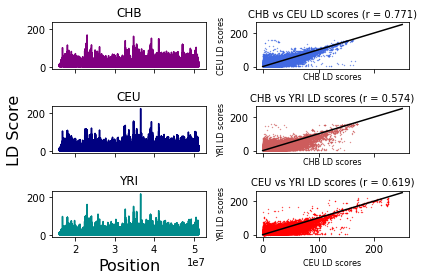

In [155]:
# Combined scatter and bar plots

import matplotlib.pyplot as plt

idx1 = (CHB_LDS > 0) 
idx2 = (CEU_LDS > 0) & (CHB_LDS > 0)
idx3 = (CEU_LDS > 0) 
idx4 = (CHB_LDS > 0) & (YRI_LDS > 0)
idx5 = (YRI_LDS > 0) 
idx6 = (CEU_LDS > 0) & (YRI_LDS > 0)

fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,sharex='col',sharey='col')

x = np.linspace(0,250,200)

ax1.plot(pos[idx1],CHB_LDS[idx1],color='purple')
ax2.scatter(CHB_LDS[idx2], CEU_LDS[idx2],s=0.1,color='royalblue')
ax2.plot(x,x,color='black')
ax3.plot(pos[idx3],CEU_LDS[idx3],color='navy')
ax4.scatter(CHB_LDS[idx4], YRI_LDS[idx4],s=0.1,color='indianred')
ax4.plot(x,x,color='black')
ax5.plot(pos[idx5],YRI_LDS[idx5],color='darkcyan')
ax6.scatter(CEU_LDS[idx6], YRI_LDS[idx6],s=0.1,color='red')
ax6.plot(x,x,color='black')

ax2.set_xlabel("CHB LD scores", fontsize=8)
ax2.set_ylabel("CEU LD scores", fontsize=8)
ax3.set_ylabel('LD Score',fontsize=16)
ax4.set_xlabel('CHB LD scores',fontsize=8)
ax4.set_ylabel('YRI LD scores',fontsize=8)
ax5.set_xlabel("Position",fontsize=16)
ax6.set_xlabel("CEU LD scores",fontsize=8)
ax6.set_ylabel("YRI LD scores",fontsize=8)

# Use code below in order to make scatter plots squares
#x0,x1 = ax2.get_xlim()
#y0,y1 = ax2.get_ylim()
#ax2.set_aspect(abs(x1-x0)/abs(y1-y0))

ax1.title.set_text("CHB")
ax2.title.set_text("CHB vs CEU LD scores (r = 0.771)")
ax2.title.set_fontsize(10)
ax3.title.set_text("CEU")
ax4.title.set_text("CHB vs YRI LD scores (r = 0.574)")
ax4.title.set_fontsize(10)
ax5.title.set_text("YRI")
ax6.title.set_text("CEU vs YRI LD scores (r = 0.619)")
ax6.title.set_fontsize(10)

plt.tight_layout()
#plt.savefig('chr22_LDS_bar_scatter.png',dpi=300)

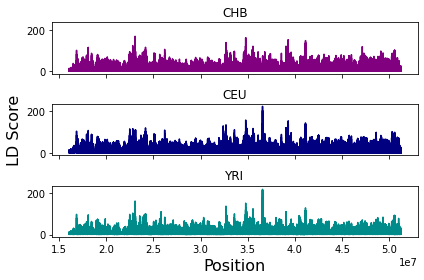

In [156]:
# Bar plots for entire chr22 to compare CHB/CEU/YRI populations

fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True,sharey=True)

idx1 = (CHB_LDS > 0) 
idx2 = (CEU_LDS > 0) 
idx3 = (YRI_LDS > 0) 

ax1.plot(pos[idx1],CHB_LDS[idx1],color='purple')
ax2.plot(pos[idx2],CEU_LDS[idx2],color='navy')
ax3.plot(pos[idx3],YRI_LDS[idx3],color='darkcyan')

ax2.set_ylabel('LD Score',fontsize=16)
ax3.set_xlabel("Position",fontsize=16)

ax1.title.set_text("CHB")
ax2.title.set_text("CEU")
ax3.title.set_text("YRI")

plt.tight_layout()
#plt.savefig('chr22_LDS_bar.png',dpi=300)

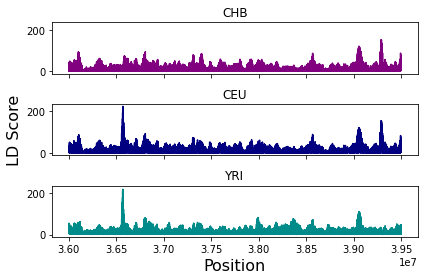

In [157]:
# Focusing on specific region of chromosome 22 

fig, (ax1,ax2,ax3) = plt.subplots(3,sharex=True,sharey=True)

lowerb = 3.6*10**7
upperb = 3.95*10**7

idx4 = (pos[idx1] > lowerb) & (pos[idx1] < upperb)
idx5 = (pos[idx2] > lowerb) & (pos[idx2] < upperb)
idx6 = (pos[idx3] > lowerb) & (pos[idx3] < upperb)

ax1.plot(pos[idx1][idx4],CHB_LDS[idx1][idx4],color='purple')
ax2.plot(pos[idx2][idx5],CEU_LDS[idx2][idx5],color='navy')
ax3.plot(pos[idx3][idx6],YRI_LDS[idx3][idx6],color='darkcyan')

ax2.set_ylabel('LD Score',fontsize=16)
ax3.set_xlabel("Position",fontsize=16)

ax1.title.set_text("CHB")
ax2.title.set_text("CEU")
ax3.title.set_text("YRI")

plt.tight_layout()

#plt.savefig('chr22_LDS_bar_region2.png',dpi=300)

array([[1.        , 0.77085096],
       [0.77085096, 1.        ]])

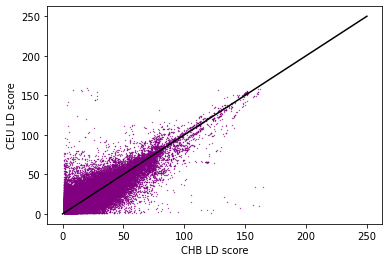

In [158]:
idx = (CEU_LDS > 0) & (CHB_LDS > 0)
plt.scatter(CHB_LDS[idx],CEU_LDS[idx],s=0.1,color='purple')
plt.xlabel("CHB LD score")
plt.ylabel("CEU LD score")
x = np.linspace(0,250,200)
plt.plot(x, x, color='black')
#np.corrcoef(CHB_LDS[idx],CEU_LDS[idx])
np.corrcoef(CHB_LDS,CEU_LDS)
#plt.savefig('CHBvsCEUscatter_chr22.png',dpi=300)

array([[1.        , 0.57421909],
       [0.57421909, 1.        ]])

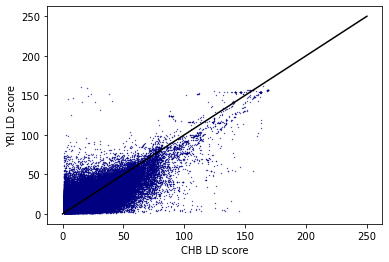

In [159]:
idx = (CHB_LDS > 0) & (YRI_LDS > 0)
plt.scatter(CHB_LDS[idx],YRI_LDS[idx], s=0.1, color = 'navy')
plt.xlabel("CHB LD score")
plt.ylabel("YRI LD score")
plt.plot(x,x,color='black')
#np.corrcoef(CHB_LDS[idx],YRI_LDS[idx])
np.corrcoef(CHB_LDS,YRI_LDS)
#plt.savefig('CHBvsYRIscatter_chr22.png',dpi=300)

array([[1.        , 0.61885442],
       [0.61885442, 1.        ]])

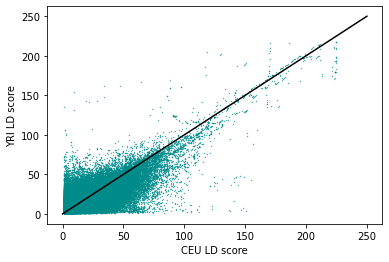

In [160]:
idx = (CEU_LDS > 0) & (YRI_LDS > 0)
plt.scatter(CEU_LDS[idx],YRI_LDS[idx], s=0.1, color='darkcyan')
plt.xlabel("CEU LD score")
plt.ylabel("YRI LD score")
plt.plot(x,x,color='black')
#np.corrcoef(CEU_LDS[idx],YRI_LDS[idx])
np.corrcoef(CEU_LDS,YRI_LDS)
#plt.savefig('CEUvsYRIscatter_chr22.png',dpi=300)

In [161]:
# Indexing function to get local triangular matrix centered on a particular SNP
import numpy as np
from tqdm import tqdm

def local_LD(a,pos_list,snp_pos):
    b = np.vstack((pos_list,a))
    c = []
    for i in tqdm(range(b.shape[1])):
        if b[0,i] == snp_pos:
            c.append(i)
    if c[0]<b.shape[0]:
        d = b[1:,:c[0]]
        e = np.tril(np.fliplr(d))
    else:
        d = b[1:,c[0]-b.shape[0]:c[0]]
        e = np.tril(np.fliplr(d))
    return e

In [5]:
x = local_LD(CEUmat,pos,16051874)

100%|██████████| 384415/384415 [00:00<00:00, 1559613.48it/s]
